In [71]:
import os
import pickle

import networkx as nx
from tqdm import tqdm

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.io_utils as io_utils
import matching.glema.common.utils.plot_utils as plot_utils
from matching.glema.common.dataset import BaseDataset

In [72]:
args = arg_utils.parse_args( use_default=True )
model_ckpt = f"{args.ckpt_dir}/CPG_undirected/best_model.pt"
args = arg_utils.load_args( args, model_ckpt )
args.ckpt = model_ckpt
#args.embedding_dim = 6
#args.directed = True
args.dataset = "CPG_augm"
args.test_data = True

In [73]:
data_path = io_utils.get_abs_file_path( os.path.join( args.data_processed_dir, args.dataset ) )
if args.directed:
    data_path += "_directed"

data_path

'/Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/data/data_processed/CPG_augm'

In [74]:
key_file = os.path.join( data_path, args.test_keys if args.test_data else args.train_keys )
with open( key_file, "rb" ) as fp:
    keys = pickle.load( fp )
print( f"Number of test data: {len( keys )}" )
iso_key_idxs = [ i for i, k in enumerate( keys ) if "iso" in k ]
non_iso_key_idxs = [ i for i, k in enumerate( keys ) if "non" in k ]
print( f"Test data split: iso [{len( iso_key_idxs )}] / noniso [{len( non_iso_key_idxs )}]" )

Number of test data: 11648
Test data split: iso [5824] / noniso [5824]


In [75]:
dataset = BaseDataset( keys, args )

In [76]:
matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}

def get_sample( dataset, sample_idx, relabel=True ):
    sample_data = dataset.get_data( sample_idx )
    query, source, mapping = sample_data
    mapping = { qnid: snid for qnid, snid in mapping }
    if relabel:
        query = graph_utils.relabel_nodes( query, mapping )
        #query = nx.relabel_nodes( query, mapping )
    return source, query, mapping


def get_colors( G ):
    return [ "purple" if d[ "anchor" ] == 1 else "grey" for n, d in G.nodes( data=True ) ]

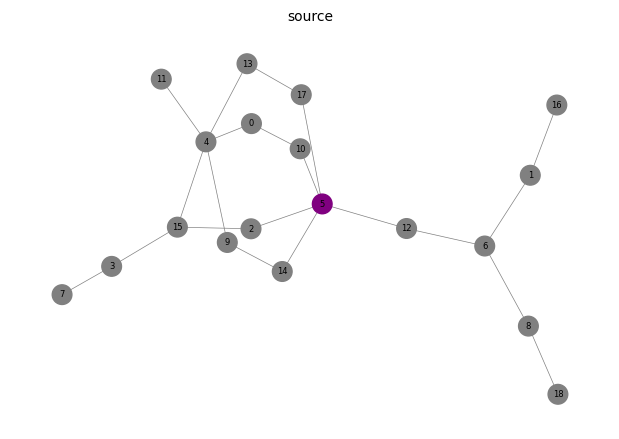

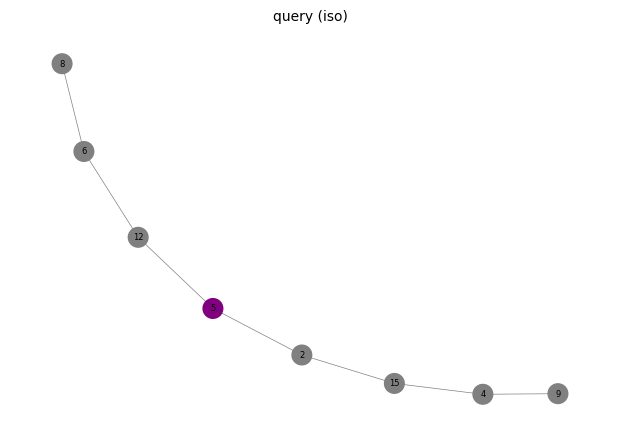

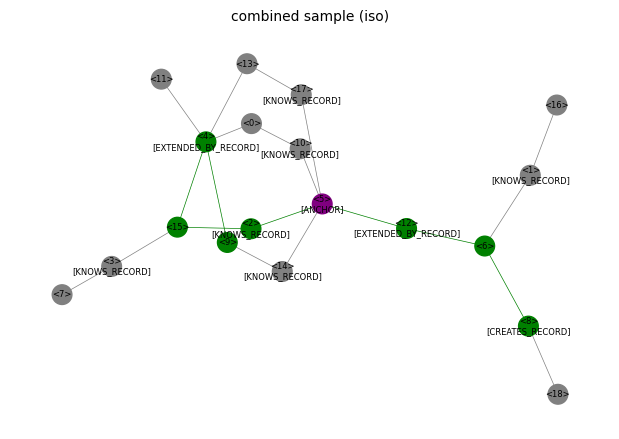

In [77]:
sample_idx = iso_key_idxs[ 0 ]
source, query, _ = get_sample( dataset, sample_idx )
plot_utils.plot_graph( title="source", graph=source, nodeColors=get_colors( source ) )
plot_utils.plot_graph( title="query (iso)", graph=query, nodeColors=get_colors( query ) )

combined, n_colors, e_colors = graph_utils.combine_graph( source, query,
                                                          matching_colors=matching_colors )
plot_utils.plot_graph(
    title="combined sample (iso)", graph=combined,
    nodeColors=n_colors, edgeColors=e_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)

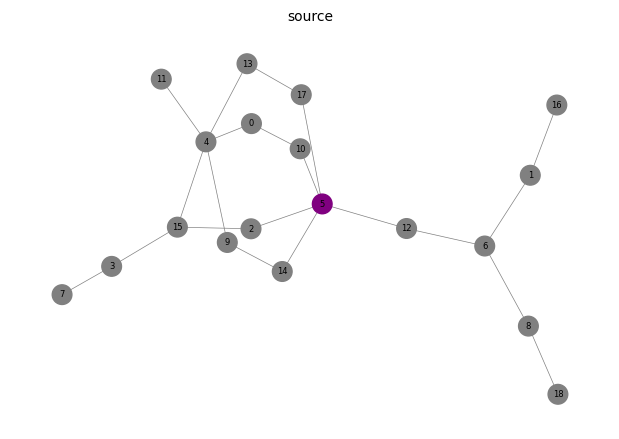

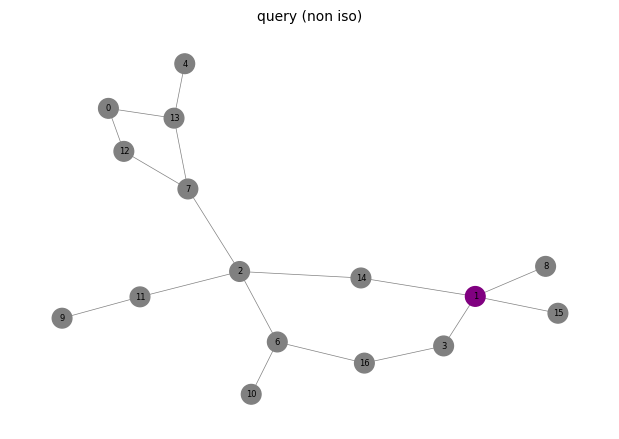

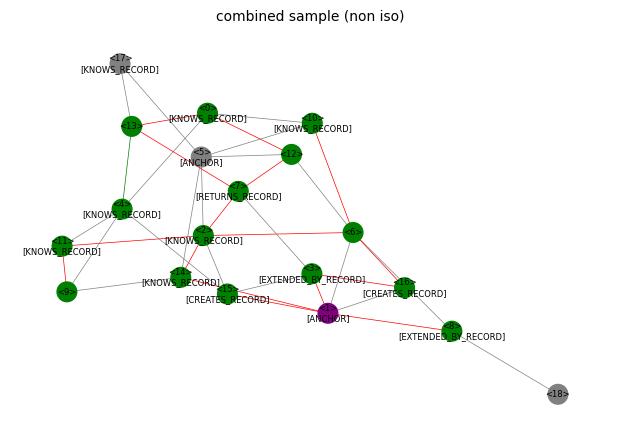

In [78]:
sample_idx = non_iso_key_idxs[ 0 ]
source, query, _ = get_sample( dataset, sample_idx )
plot_utils.plot_graph( title="source", graph=source, nodeColors=get_colors( source ) )
plot_utils.plot_graph( title="query (non iso)", graph=query, nodeColors=get_colors( query ) )

combined, n_colors, e_colors = graph_utils.combine_graph( source, query,
                                                          matching_colors=matching_colors )
plot_utils.plot_graph(
    title="combined sample (non iso)", graph=combined,
    nodeColors=n_colors, edgeColors=e_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)

In [79]:
sample_tensors = dataset.__getitem__( sample_idx )
sample_tensors

{'H': array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 

In [80]:
sources_with_anchor = 0
queries_with_anchor = 0
iso_samples_with_same_anchor = 0
non_iso_samples_with_same_anchor = 0
for sample_idx in tqdm( list( range( len( keys ) ) ) ):
    
    is_iso_sample = False
    if sample_idx in iso_key_idxs:
        is_iso_sample = True
    
    query, source, mapping = get_sample( dataset, sample_idx, relabel=True )

    source_anchor = graph_utils.get_anchor( source )
    if source_anchor >= 0:
        sources_with_anchor += 1
        
    query_anchor = graph_utils.get_anchor( query )
    if query_anchor >= 0:
        queries_with_anchor += 1
        
        if source_anchor == query_anchor:
            if is_iso_sample:
                iso_samples_with_same_anchor += 1
            else:
                non_iso_samples_with_same_anchor += 1

print( f"Sources with anchor: {sources_with_anchor}/{len( keys )}" )
print( f"Queries with anchor: {queries_with_anchor}/{len( keys )}" )
print( f"Iso samples with same anchor: {iso_samples_with_same_anchor}/{len( iso_key_idxs )}" )
print( f"Non iso samples with same anchor: {non_iso_samples_with_same_anchor}/{len( non_iso_key_idxs )}" )

100%|██████████| 11648/11648 [00:01<00:00, 10607.97it/s]

Sources with anchor: 11648/11648
Queries with anchor: 11648/11648
Iso samples with same anchor: 5824/5824
Non iso samples with same anchor: 1047/5824
